In [245]:
#https://www.alphavantage.co/academy/#ai-for-finance

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from alpha_vantage.timeseries import TimeSeries 

print("All libraries loaded")

All libraries loaded


In [246]:
config = {
    "alpha_vantage": {
        "key": 'NA4DC7S59VGKCP4Y', # you can use the demo API key for this project, but please make sure to get your own API key at https://www.alphavantage.co/support/#api-key
        "symbol": "IBM",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    },

    "alpha_vantage": {
        "symbol": "AAPL",  # Replace with your desired symbol
        "outputsize": "full",  # Replace with your desired output size
        "key_adjusted_close": "5. adjusted close"  # Replace with the appropriate key for adjusted close price
    },
    "plots": {
        "color_actual": "blue",  # Replace with your desired color
        "xticks_interval": 10  # Replace with your desired interval for x-ticks
    }

    
}

In [247]:
import requests
import pandas as pd
from pandas.io.json import json_normalize

# Replace the "demo" API key below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=INFLATION&apikey=NA4DC7S59VGKCP4Y'
r = requests.get(url)
data = r.json()

# Convert the data to a pandas DataFrame
df = pd.DataFrame.from_dict(data)

# Normalize the "data" column
inflation = json_normalize(df['data'])

# Add the normalized data as columns to the DataFrame
df['date'] = inflation['date']
df['value'] = inflation['value']

# Rename the 'DATE' column to 'Date'
inflation.rename(columns={'date': 'Date'}, inplace=True)

# Filter the data based on the desired date range
start_date = '2010-06-01'
end_date = '2023-06-30'
filtered_inflation = inflation[(inflation['Date'] >= start_date) & (inflation['Date'] <= end_date)]

filtered_inflation

/var/folders/qy/3nm4yxds0yqgsybrtw7vhftm0000gn/T/ipykernel_26858/1845003002.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  inflation = json_normalize(df['data'])


,Date,value
0,2022-01-01,8.00279982052117
1,2021-01-01,4.69785886363739
2,2020-01-01,1.23358439630637
3,2019-01-01,1.81221007526015
4,2018-01-01,2.44258329692818
5,2017-01-01,2.13011000365963
6,2016-01-01,1.26158320570537
7,2015-01-01,0.118627135552435
8,2014-01-01,1.62222297740821
9,2013-01-01,1.46483265562714


In [248]:
import pandas as pd
import requests

# Replace "demo" with your own API key from https://www.alphavantage.co/support/#api-key
apikey = "NA4DC7S59VGKCP4Y"
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=IBM&apikey={apikey}&outputsize=full'

# Send a GET request to the API
r = requests.get(url)
data = r.json()

# Extract the time series data
time_series = data['Time Series (Daily)']

# Create a DataFrame from the time series data
df = pd.DataFrame(time_series).T

# Rename the columns
df.columns = ['Open', 'High', 'Low', 'Close', 'Adjusted Close', 'Volume', 'Dividend Amount', 'Split Coefficient']

# Convert the column data types
df = df.astype({
    'Open': float,
    'High': float,
    'Low': float,
    'Close': float,
    'Adjusted Close': float,
    'Volume': int,
    'Dividend Amount': float,
    'Split Coefficient': float
})

# Sort the DataFrame by date
df.sort_index(ascending=True, inplace=True)

# Reset the index
df.reset_index(inplace=True)

df.rename(columns={'index': 'Date'}, inplace=True)

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Specify the desired start and end dates
start_date = '2010-06-01'
end_date = '2023-06-30'

# Filter the DataFrame based on the start and end dates
filtered_basic = df.loc[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Reset the index without keeping the original index values
filtered_basic.reset_index(drop=True, inplace=True)

# Display the filtered DataFrame
print(filtered_basic.head)



<bound method NDFrame.head of            Date    Open    High      Low   Close  Adjusted Close   Volume  \
0    2010-06-01  124.69  126.88  124.200  124.34       75.027740  7135400   
1    2010-06-02  124.85  127.50  124.350  127.41       76.880202  7705300   
2    2010-06-03  127.75  128.22  126.460  127.96       77.212077  6645300   
3    2010-06-04  126.37  127.10  124.670  125.28       75.594944  9669200   
4    2010-06-07  125.57  125.86  124.130  124.13       74.901024  6951400   
...         ...     ...     ...      ...     ...             ...      ...   
3289 2023-06-26  129.39  131.41  129.310  131.34      131.340000  4845649   
3290 2023-06-27  131.30  132.95  130.830  132.34      132.340000  3219909   
3291 2023-06-28  132.06  132.17  130.910  131.76      131.760000  2753779   
3292 2023-06-29  131.75  134.35  131.690  134.06      134.060000  3639836   
3293 2023-06-30  134.69  135.03  133.425  133.81      133.810000  4236677   

      Dividend Amount  Split Coefficient  
0 

In [253]:
# Convert the 'Date' column in filtered_inflation to datetime
filtered_inflation['Date'] = pd.to_datetime(filtered_inflation['Date'])

import pandas as pd

# Merge the inflation dataset using concat
merged_data = pd.concat([filtered_basic.set_index('Date'), filtered_inflation.set_index('Date')['value']], axis=1, join='outer')

# Fill missing values for all columns
merged_data.fillna(method='ffill', inplace=True)
merged_data.fillna(method='bfill', inplace=True)

# Check missing values
missing_values = merged_data.isnull().sum()
print(missing_values)

# Display the merged DataFrame
print(merged_data)


Open                 0
High                 0
Low                  0
Close                0
Adjusted Close       0
Volume               0
Dividend Amount      0
Split Coefficient    0
value                0
dtype: int64
              Open    High      Low   Close  Adjusted Close     Volume  \
Date                                                                     
2010-06-01  124.69  126.88  124.200  124.34       75.027740  7135400.0   
2010-06-02  124.85  127.50  124.350  127.41       76.880202  7705300.0   
2010-06-03  127.75  128.22  126.460  127.96       77.212077  6645300.0   
2010-06-04  126.37  127.10  124.670  125.28       75.594944  9669200.0   
2010-06-07  125.57  125.86  124.130  124.13       74.901024  6951400.0   
...            ...     ...      ...     ...             ...        ...   
2023-06-26  129.39  131.41  129.310  131.34      131.340000  4845649.0   
2023-06-27  131.30  132.95  130.830  132.34      132.340000  3219909.0   
2023-06-28  132.06  132.17  130.910  131

/var/folders/qy/3nm4yxds0yqgsybrtw7vhftm0000gn/T/ipykernel_26858/2191908937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_inflation['Date'] = pd.to_datetime(filtered_inflation['Date'])


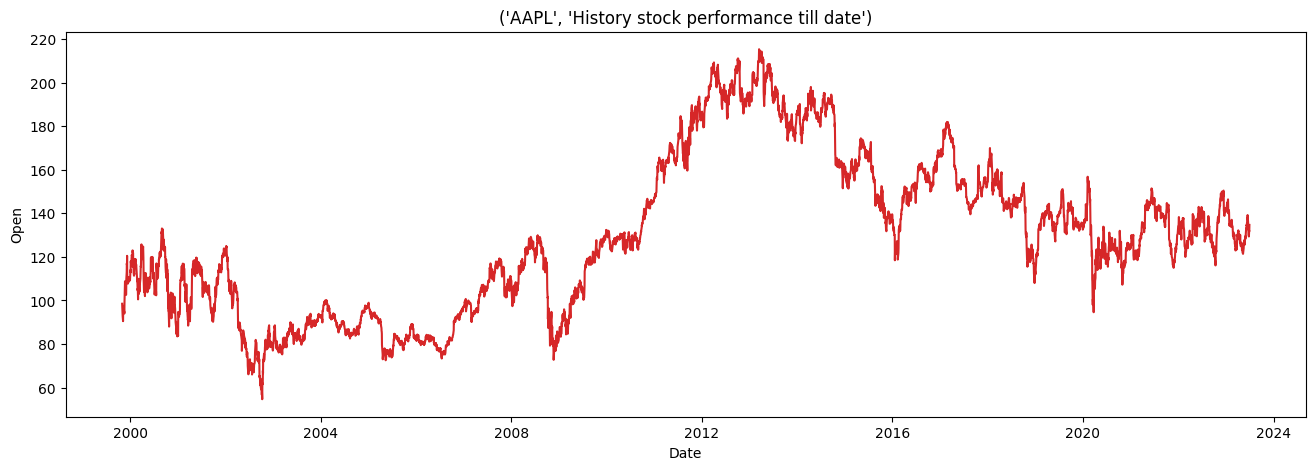

In [254]:
#Graph stock performance

import matplotlib.pyplot as plt

# defining x and y 
x = df['Date']
y = df['Open']

# Define your df_plot function
def df_plot(data, x, y, title="", xlabel='Date', ylabel='Open', dpi=100):
    plt.figure(figsize=(16, 5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

# Rest of your code

title = ('AAPL', "History stock performance till date")
df_plot(df, x, y, title=title, xlabel='Date', ylabel='Open', dpi=100)


In [271]:
#normalize data

class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=0)
        self.sd = np.std(x, axis=0)
        normalized_x = (x - self.mu) / self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x * self.sd) + self.mu


# normalize
scaler = Normalizer()


# Normalize the selected columns
normalized_data = scaler.fit_transform(merged_data)


In [ ]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]


def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

# split dataset

split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

# prepare data for plotting

to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)

to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

## plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
plt.legend()
plt.show()

KeyError: 'color_train'

<Figure size 2000x400 with 0 Axes>

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

Train data shape (4747, 20, 1) (4747,)
Validation data shape (1187, 20, 1) (1187,)


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

In [ ]:

def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

Epoch[1/100] | loss train:0.055890, test:0.002593 | lr:0.010000
Epoch[2/100] | loss train:0.013106, test:0.002116 | lr:0.010000
Epoch[3/100] | loss train:0.009846, test:0.002833 | lr:0.010000
Epoch[4/100] | loss train:0.008768, test:0.002662 | lr:0.010000
Epoch[5/100] | loss train:0.010741, test:0.001530 | lr:0.010000
Epoch[6/100] | loss train:0.008222, test:0.003525 | lr:0.010000
Epoch[7/100] | loss train:0.009985, test:0.001196 | lr:0.010000
Epoch[8/100] | loss train:0.008625, test:0.002198 | lr:0.010000
Epoch[9/100] | loss train:0.008778, test:0.001569 | lr:0.010000
Epoch[10/100] | loss train:0.009642, test:0.001353 | lr:0.010000
Epoch[11/100] | loss train:0.008552, test:0.001389 | lr:0.010000
Epoch[12/100] | loss train:0.008245, test:0.001399 | lr:0.010000
Epoch[13/100] | loss train:0.009807, test:0.001400 | lr:0.010000
Epoch[14/100] | loss train:0.009435, test:0.001716 | lr:0.010000
Epoch[15/100] | loss train:0.008074, test:0.001414 | lr:0.010000
Epoch[16/100] | loss train:0.00997

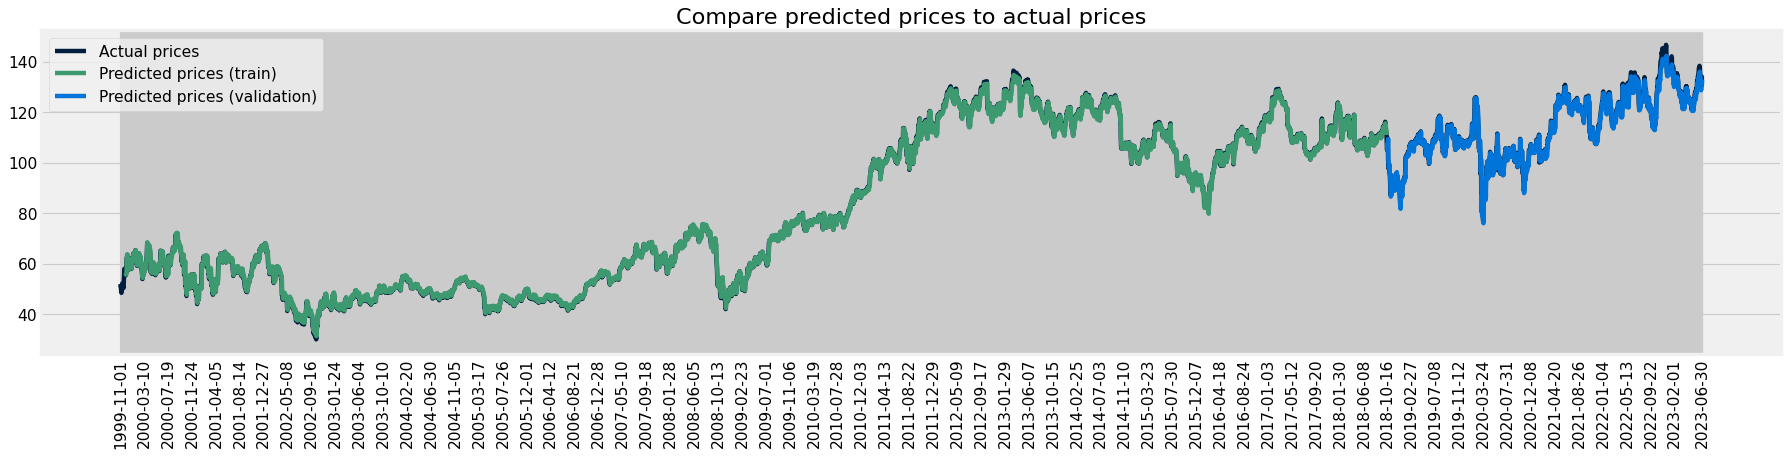

In [ ]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

# prepare data for plotting

to_plot_data_y_train_pred = np.zeros(num_data_points)
to_plot_data_y_val_pred = np.zeros(num_data_points)

to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Compare predicted prices to actual prices")
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.legend()
plt.show()

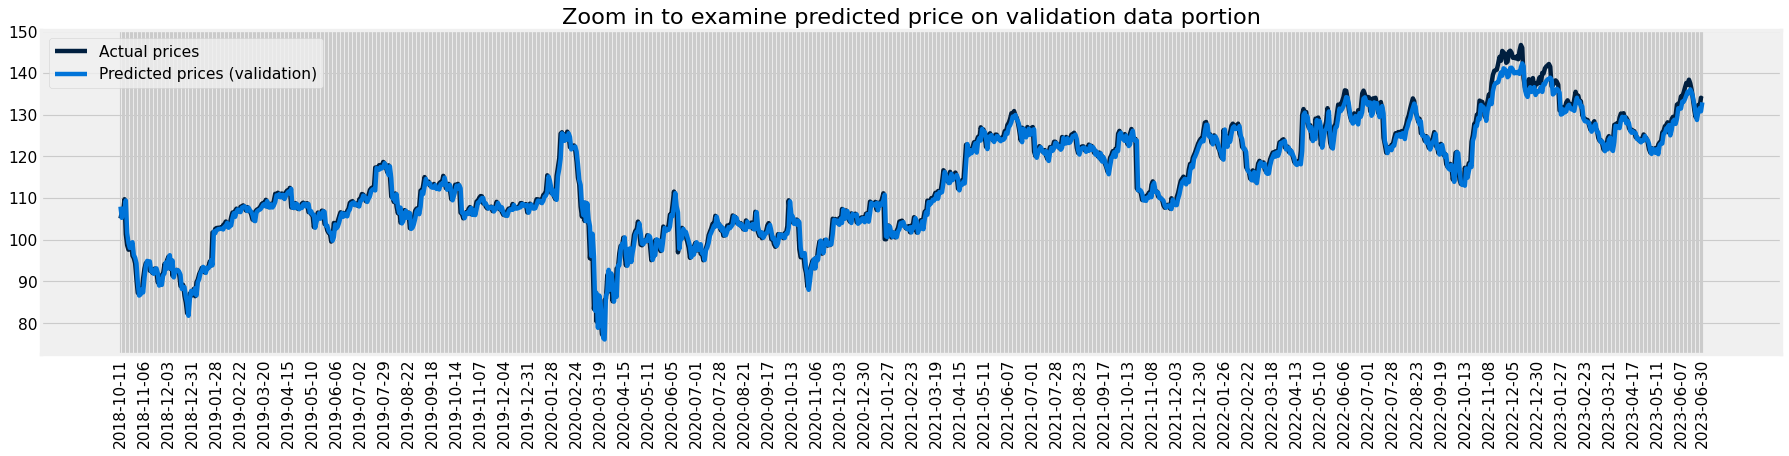

In [ ]:
# prepare data for plotting the zoomed in view of the predicted prices (on validation set) vs. actual prices

to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
to_plot_predicted_val = scaler.inverse_transform(predicted_val)
to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Zoom in to examine predicted price on validation data portion")
xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
xs = np.arange(0,len(xticks))
plt.xticks(xs, xticks, rotation='vertical')
plt.legend()
plt.show()

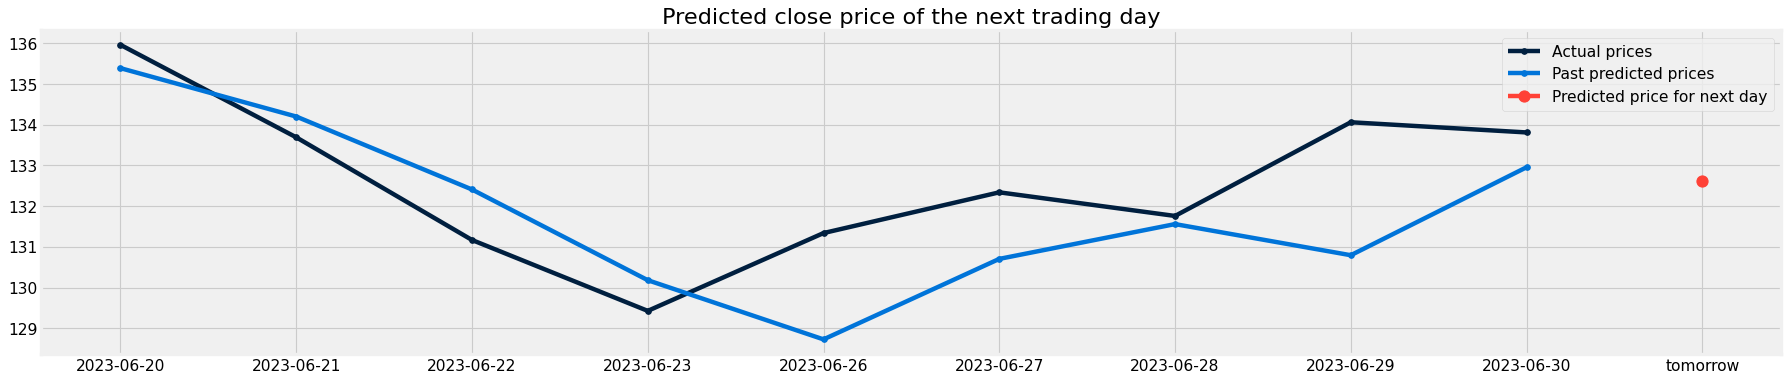

Predicted close price of the next trading day: 132.63


In [ ]:
# predict the closing price of the next trading day

model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()

# prepare plots

plot_range = 10
to_plot_data_y_val = np.zeros(plot_range)
to_plot_data_y_val_pred = np.zeros(plot_range)
to_plot_data_y_test_pred = np.zeros(plot_range)

to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

to_plot_data_y_test_pred[plot_range-1] = scaler.inverse_transform(prediction)

to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

# plot

plot_date_test = data_date[-plot_range+1:]
plot_date_test.append("tomorrow")

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
plt.title("Predicted close price of the next trading day")
plt.legend()
plt.show()

print("Predicted close price of the next trading day:", round(to_plot_data_y_test_pred[plot_range-1], 2))